Benchmarking results files must be placed in the following manner:

```
- benchmarking-results-for-visualizations
  - json-accuracy
    - llm-img2json
      - model
        - llm-img2json_<cleaning_method>_<time_str>.csv
        - ...
    - llm-txt2json
      - model
        - llm-txt2json_<cleaning_method>_<time_str>.csv
        - ...
  - txt-accuracy
    - llm-img2txt
      - model
        - <cleaning_method>_<time_str>.csv
        - ...
    - ocr-img2txt
      - ...
    - ocr-llm-img2txt
      - ...
```    

# Open multiple results files using Pandas

In [290]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob
import math

ROOT_DIR = Path.cwd().parent.parent

# For reference only
TXT_PARENT_DIR = ROOT_DIR / 'benchmarking-results-for-visualizations' / 'txt-accuracy'
TXT_SUB_DIRS = ['llm-img2txt', 'ocr-img2txt', 'ocr-llm-img2txt']

JSON_PARENT_DIR = ROOT_DIR / 'benchmarking-results-for-visualizations' / 'json-accuracy'
JSON_SUB_DIRS = ['llm-img2json', 'llm-txt2json']

# The columns of the dataframe that doesn't correspond to the columns
DF_INFO_COLS = ['sub_dir', 'cleaning_method', 'time_str', 'doc', 'metric']

def process_dfs(df: pd.DataFrame, sub_dir: str, filename: str) -> pd.DataFrame:
        """
        Returns a new dataframe with the following operations applied:
        - Adds the column `sub_dir`, which is the subdirectory the file is located in (i.e. img2json) found from the sub_dir parameter.
        - Adds the column `cleaning_method`, which contains either 'normalized', 'nonorm', or 'fuzzy' found from the cleaning_method parameter.
        - Adds the column `time_str`, which is a string representing the time of file creation found from the name parameter.
        - Splits the previously-unnamed column into a `doc` and `metric` column
        """
        old_cols = list(df.columns)
        new_cols = ["sub_dir", "cleaning_method", "time_str", "doc", "metric"] + old_cols

        # Filename format: assume the following; others are invalid
        # - llm-img2json_<cleaning_method>_<time_str>.csv
        # - llm-txt2json_<cleaning_method>_<time_str>.csv
        # - <cleaning_method>_<time_str>.csv

        filename_split = filename.split("_")
        cleaning_method = "_".join(filename_split[:-2]).removeprefix("llm-img2json_").removeprefix("llm-txt2json_")
        time_str = "_".join(filename_split[-2:]).removesuffix(".csv")

        processed_df = df.copy()
        processed_df["sub_dir"] = sub_dir
        processed_df["cleaning_method"] = cleaning_method
        processed_df["time_str"] = time_str
        processed_df["doc"] = processed_df["Unnamed: 0"].apply(lambda x: (x.split(":")[0]))
        processed_df["metric"] = processed_df["Unnamed: 0"].apply(lambda x: ":".join(x.split(":")[1:]))
        processed_df = processed_df[new_cols]
        processed_df = processed_df.drop(columns="Unnamed: 0")

        return processed_df


def open_benchmarking_results_folder(parent_dir: Path, sub_dir: str) -> pd.DataFrame:
    """
    Opens all of the benchmarking results within a single directory following the specified parameters.
    `search_pattern` is handled using glob.

    Returns a list with dataframes.
    """

    file_paths = (parent_dir / sub_dir).glob('*.csv')
    dataframes = [
        process_dfs(
            pd.read_csv(parent_dir / sub_dir / path), sub_dir, path.name
        ) for path in file_paths
    ]

    combined = pd.concat(dataframes, ignore_index=True)
    return combined


def open_all_benchmarking_results(parent_dir: Path, sub_dirs: list[str]):
    """
    Opens all of the benchmarking results for either text or JSON output.

    Returns a combined dataframe.
    """
    dataframes = [
        open_benchmarking_results_folder(parent_dir, sub_dir) for sub_dir in sub_dirs
    ]
    combined = pd.concat(dataframes, ignore_index=True)
    return combined


txt_bm = open_all_benchmarking_results(TXT_PARENT_DIR, TXT_SUB_DIRS)
json_bm = open_all_benchmarking_results(JSON_PARENT_DIR, JSON_SUB_DIRS)

# Text benchmarking results

In [291]:
txt_bm

,sub_dir,cleaning_method,time_str,doc,metric,gemini-2.5-flash,gpt-4o,pytesseract
0,llm-img2txt,normalized,2025-07-16_12-01-57-tim1,kbaa-p003,dist_char,6.000000,6.000000,NaN
1,llm-img2txt,normalized,2025-07-16_12-01-57-tim1,kbaa-p003,doc_len,2584.000000,2584.000000,NaN
2,llm-img2txt,normalized,2025-07-16_12-01-57-tim1,kbaa-p003,cer_pct,0.232198,0.232198,NaN
3,llm-img2txt,normalized,2025-07-16_12-01-57-tim1,kbaa-p003,wer_pct,0.427350,0.641026,NaN
4,llm-img2txt,normalized,2025-07-16_12-01-57-tim1,kbaa-p003,token_sort_ratio,99.883766,99.883811,NaN
...,...,...,...,...,...,...,...,...
6595,ocr-llm-img2txt,nonorm,2025-07-16_12-32-23-muhammad2,__ALL__,dist_char,10638.000000,2668.000000,NaN
6596,ocr-llm-img2txt,nonorm,2025-07-16_12-32-23-muhammad2,__ALL__,doc_len,155972.000000,155972.000000,NaN
6597,ocr-llm-img2txt,nonorm,2025-07-16_12-32-23-muhammad2,__ALL__,cer_pct,6.820455,1.710563,NaN
6598,ocr-llm-img2txt,nonorm,2025-07-16_12-32-23-muhammad2,__ALL__,wer_pct,8.843069,3.657944,NaN


## Move pytesseract results alongside LLM results

In [292]:
# Split txt results to (llm-img2txt + ocr-llm-img2txt) and (ocr-img2txt)
llm_txt = txt_bm[txt_bm['sub_dir'] != 'ocr-img2txt']
ocr_txt = txt_bm[txt_bm['sub_dir'] == 'ocr-img2txt']

# Fill in llm-img2txt columns
for index, row in llm_txt.iterrows():
    cleaning_method = row['cleaning_method']
    time_str = row['time_str']
    doc = row['doc']
    metric = row['metric']

    ocr_metric = ocr_txt.loc[
        (ocr_txt['cleaning_method'] == cleaning_method) &
        (ocr_txt['time_str'] == time_str) &
        (ocr_txt['doc'] == doc) &
        (ocr_txt['metric'] == metric),
        'pytesseract'
    ]
    if not ocr_metric.empty:
        llm_txt.loc[index, 'pytesseract'] = ocr_metric.iloc[0]

llm_txt

,sub_dir,cleaning_method,time_str,doc,metric,gemini-2.5-flash,gpt-4o,pytesseract
0,llm-img2txt,normalized,2025-07-16_12-01-57-tim1,kbaa-p003,dist_char,6.000000,6.000000,139.000000
1,llm-img2txt,normalized,2025-07-16_12-01-57-tim1,kbaa-p003,doc_len,2584.000000,2584.000000,2584.000000
2,llm-img2txt,normalized,2025-07-16_12-01-57-tim1,kbaa-p003,cer_pct,0.232198,0.232198,5.379257
3,llm-img2txt,normalized,2025-07-16_12-01-57-tim1,kbaa-p003,wer_pct,0.427350,0.641026,16.666667
4,llm-img2txt,normalized,2025-07-16_12-01-57-tim1,kbaa-p003,token_sort_ratio,99.883766,99.883811,95.116773
...,...,...,...,...,...,...,...,...
6595,ocr-llm-img2txt,nonorm,2025-07-16_12-32-23-muhammad2,__ALL__,dist_char,10638.000000,2668.000000,14259.000000
6596,ocr-llm-img2txt,nonorm,2025-07-16_12-32-23-muhammad2,__ALL__,doc_len,155972.000000,155972.000000,155972.000000
6597,ocr-llm-img2txt,nonorm,2025-07-16_12-32-23-muhammad2,__ALL__,cer_pct,6.820455,1.710563,9.142025
6598,ocr-llm-img2txt,nonorm,2025-07-16_12-32-23-muhammad2,__ALL__,wer_pct,8.843069,3.657944,14.510249


In [293]:
# Make sure all rows are matched to pytesseract metric:
llm_txt.isna().sum()

sub_dir             0
cleaning_method     0
time_str            0
doc                 0
metric              0
gemini-2.5-flash    0
gpt-4o              0
pytesseract         0
dtype: int64

# Calculate metrics

In [294]:
# Use for filtering entries that are for "__ALL__" documents or single documents.
txt_all_docs = llm_txt['doc'] == '__ALL__'

# Use for filtering only error rates.
txt_error_rates = (
    (llm_txt['metric'] == 'cer_pct') |
    (llm_txt['metric'] == 'wer_pct') |
    (llm_txt['metric'] == 'token_sort_ratio')
)

In [295]:
llm_txt_grouped = llm_txt[~txt_all_docs].drop(columns=['doc', 'time_str']).groupby(['sub_dir', 'cleaning_method', 'metric'])
llm_txt_grouped_mean = llm_txt_grouped.mean()
llm_txt_grouped_mean

gemini-2.5-flash  \
sub_dir         cleaning_method metric                               
llm-img2txt                     cer_pct                   4.073582   
                                dist_char               142.523256   
                                doc_len                3467.686047   
                                token_sort_ratio         98.943257   
                                wer_pct                   6.160362   
                nonorm          cer_pct                   5.888627   
                                dist_char               213.829457   
                                doc_len                3633.162791   
                                token_sort_ratio         98.624268   
                                wer_pct                   9.220439   
                normalized      cer_pct                   4.762330   
                                dist_char               156.480620   
                                doc_len                3295.573643   
                                token_sort_ratio         99.326687   
                                wer_pct                   5.708585   
ocr-llm-img2txt                 cer_pct                   4.601911   
                                dist_char               160.325581   
                                doc_len                3467.686047   
                                token_sort_ratio         98.776788   
                                wer_pct                   6.316290   
                nonorm          cer_pct                   5.948441   
                                dist_char               215.410853   
                                doc_len                3633.162791   
                                token_sort_ratio         97.731820   
                                wer_pct                   8.231774   
                normalized      cer_pct                   4.760878   
                                dist_char               156.341085   
                                doc_len                3295.573643   
                                token_sort_ratio         98.383833   
                                wer_pct                   5.862554   

                                                       gpt-4o  pytesseract  
sub_dir         cleaning_method metric                                      
llm-img2txt                     cer_pct              3.004977     9.903682  
                                dist_char          105.436047   345.488372  
                                doc_len           3467.686047  3467.686047  
                                token_sort_ratio    98.759070    97.678186  
                                wer_pct              4.441594    14.553558  
                nonorm          cer_pct              1.776354     9.225397  
                                dist_char           65.379845   335.069767  
                                doc_len           3633.162791  3633.162791  
                                token_sort_ratio    98.686345    96.971449  
                                wer_pct              4.058615    14.784670  
                normalized      cer_pct              1.357321     7.007143  
                                dist_char           45.379845   231.031008  
                                doc_len           3295.573643  3295.573643  
                                token_sort_ratio    99.300467    98.006718  
                                wer_pct              1.726521    10.687394  
ocr-llm-img2txt                 cer_pct              1.462530     9.903682  
                                dist_char           51.122093   345.488372  
                                doc_len           3467.686047  3467.686047  
                                token_sort_ratio    98.929921    97.678186  
                                wer_pct              2.639265    14.553558  
                nonorm          cer_pct              1.800980     9.225397  
                                dist_c

In [296]:
llm_txt_grouped_std = llm_txt_grouped.std()
llm_txt_grouped_std

gemini-2.5-flash  \
sub_dir         cleaning_method metric                               
llm-img2txt                     cer_pct                   2.996748   
                                dist_char               107.029343   
                                doc_len                 217.798730   
                                token_sort_ratio          0.874612   
                                wer_pct                   4.322532   
                nonorm          cer_pct                   9.487252   
                                dist_char               339.903390   
                                doc_len                 139.335297   
                                token_sort_ratio          1.048519   
                                wer_pct                  10.300765   
                normalized      cer_pct                   9.263662   
                                dist_char               298.926232   
                                doc_len                 135.950461   
                                token_sort_ratio          0.526060   
                                wer_pct                  10.441543   
ocr-llm-img2txt                 cer_pct                   3.132520   
                                dist_char               110.592285   
                                doc_len                 217.798730   
                                token_sort_ratio          0.907412   
                                wer_pct                   4.168914   
                nonorm          cer_pct                   9.109258   
                                dist_char               325.283929   
                                doc_len                 139.335297   
                                token_sort_ratio          8.730116   
                                wer_pct                   9.175006   
                normalized      cer_pct                   8.932932   
                                dist_char               289.756026   
                                doc_len                 135.950461   
                                token_sort_ratio          8.749514   
                                wer_pct                   9.201162   

                                                      gpt-4o  pytesseract  
sub_dir         cleaning_method metric                                     
llm-img2txt                     cer_pct             2.864412    10.488142  
                                dist_char         102.237549   366.868166  
                                doc_len           217.798730   217.798730  
                                token_sort_ratio    0.942505     1.416624  
                                wer_pct             3.570900    12.314916  
                nonorm          cer_pct             1.765911     1.198156  
                                dist_char          67.342431    44.459284  
                                doc_len           139.335297   139.335297  
                                token_sort_ratio    0.997063     1.473397  
                                wer_pct             2.422195     3.144801  
                normalized      cer_pct             1.443953     1.077899  
                                dist_char          49.851372    36.790568  
                                doc_len           135.950461   135.950461  
                                token_sort_ratio    0.485002     1.286027  
                                wer_pct             2.012592     2.576280  
ocr-llm-img2txt                 cer_pct             0.781093    10.488142  
                                dist_char          27.682455   366.868166  
                                doc_len           217.798730   217.798730  
                                token_sort_ratio    0.823377     1.416624  
                                wer_pct             1.830814    12.314916  
                nonorm          cer_pct             1.204482     1.198156  
                                dist_char          44.154169 

Note: we can also group only the "\__ALL__" results which would give us differences between each run.

# JSON benchmarking results

In [297]:
json_bm

,sub_dir,cleaning_method,time_str,doc,metric,gemini-2.5-flash,gpt-4o
0,llm-img2json,fuzzy,2025-07-16_12-02-30-tim1,kbaa-p114,__COL__:lastname,23,23
1,llm-img2json,fuzzy,2025-07-16_12-02-30-tim1,kbaa-p114,__COL__:firstname,21,22
2,llm-img2json,fuzzy,2025-07-16_12-02-30-tim1,kbaa-p114,__COL__:maidenname,23,23
3,llm-img2json,fuzzy,2025-07-16_12-02-30-tim1,kbaa-p114,__COL__:birthyear,23,23
4,llm-img2json,fuzzy,2025-07-16_12-02-30-tim1,kbaa-p114,__COL__:deathyear,23,23
...,...,...,...,...,...,...,...
25645,llm-txt2json,fuzzy,2025-07-16_17-15-37-amelia1,kbaa-p121,__COL__:publishyear,NaN,22
25646,llm-txt2json,fuzzy,2025-07-16_17-15-37-amelia1,kbaa-p121,__COL__:pagecount,NaN,22
25647,llm-txt2json,fuzzy,2025-07-16_17-15-37-amelia1,kbaa-p121,__COL__:library,NaN,22
25648,llm-txt2json,fuzzy,2025-07-16_17-15-37-amelia1,kbaa-p121,__COL__:description,NaN,22


In [298]:
json_only_all_docs = json_bm['doc'] == '__ALL__'
json_only_cols = json_bm['metric'].str.contains(r'__COL__:', regex=True)
json_only_int_results = (json_bm['metric'] != 'matches_pct') & (json_bm['metric'] != 'mismatch_bool')

Sums:

In [299]:
json_bm_int_all = json_bm[json_only_all_docs & json_only_int_results]
json_bm_int_all['gemini-2.5-flash'] = json_bm_int_all['gemini-2.5-flash'].astype('int')
json_bm_int_all['gpt-4o'] = json_bm_int_all['gpt-4o'].astype('int')
json_bm_int_all_grouped = json_bm_int_all.drop(columns=['doc', 'time_str']).groupby(['sub_dir', 'cleaning_method', 'metric'])
json_sum = json_bm_int_all_grouped.sum()
json_sum.head(25)

/var/folders/m5/6xyycgq524n9v3cr66xmtqlc0000gn/T/ipykernel_38648/148852913.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  json_bm_int_all['gemini-2.5-flash'] = json_bm_int_all['gemini-2.5-flash'].astype('int')
/var/folders/m5/6xyycgq524n9v3cr66xmtqlc0000gn/T/ipykernel_38648/148852913.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  json_bm_int_all['gpt-4o'] = json_bm_int_all['gpt-4o'].astype('int')


gemini-2.5-flash  gpt-4o
sub_dir      cleaning_method metric                                        
llm-img2json fuzzy           __COL__:birthyear                 3826    3096
                             __COL__:city                      3748    2982
                             __COL__:deathyear                 3902    3264
                             __COL__:description               3439    2789
                             __COL__:firstname                 3688    2997
                             __COL__:index                     3794    3087
                             __COL__:lastname                  3831    3238
                             __COL__:library                   3735    2635
                             __COL__:maidenname                3918    3380
                             __COL__:pagecount                 3763    2971
                             __COL__:publisher                 3731    2889
                             __COL__:publishyear               3762    2998
                             __COL__:title                     3637    2832
                             counted_nrows                     3981    3471
                             gt_nrows                          4408    4408
                             matches                          48774   39158
                             mismatched_dim_count                20      44
                             pred_adj_nrows                    4381    4290
                             pred_nrows                        4292    4168
                             total                            51753   45123
             nonorm          __COL__:birthyear                 3826    3096
                             __COL__:city                      3718    2922
                             __COL__:deathyear                 3902    3264
                             __COL__:description               3148    2439
                             __COL__:firstname                 3628    2840

In [300]:
# Create per-column percentages
json_col_pct = pd.DataFrame(columns=json_sum.columns, index=json_sum.index)
json_matches_pct = pd.DataFrame(columns=json_sum.columns, index=json_sum.index)
json_nrows_pct = pd.DataFrame(columns=json_sum.columns, index=json_sum.index)

for index, row in json_sum.iterrows():
    if index[2].startswith('__COL__:'):
        row_pcts = row / json_sum.loc[index[0], index[1], 'counted_nrows'] * 100
        json_col_pct.loc[index] = row_pcts
    if index[2] == 'matches':
        matches_pcts = row / json_sum.loc[index[0], index[1], 'total'] * 100
        json_matches_pct.loc[index] = matches_pcts
    if index[2] == 'counted_nrows' or index[2] == 'pred_nrows':
        nrows_pcts = row / json_sum.loc[index[0], index[1], 'gt_nrows'] * 100
        json_nrows_pct.loc[index] = nrows_pcts

json_col_pct = json_col_pct.dropna()
json_matches_pct = json_matches_pct.dropna()
json_nrows_pct = json_nrows_pct.dropna()
json_col_pct

gemini-2.5-flash     gpt-4o
sub_dir      cleaning_method metric                                         
llm-img2json fuzzy           __COL__:birthyear          96.106506  89.196197
                             __COL__:city               94.147199  85.911841
                             __COL__:deathyear          98.015574  94.036301
                             __COL__:description         86.38533  80.351484
                             __COL__:firstname           92.64004  86.343993
...                                                           ...        ...
llm-txt2json normalized      __COL__:maidenname         98.549223  98.230578
                             __COL__:pagecount          92.512953  86.729334
                             __COL__:publisher          91.606218  86.784628
                             __COL__:publishyear        92.176166  87.337573
                             __COL__:title              86.994819  81.061653

[78 rows x 2 columns]

In [301]:
json_matches_pct

gemini-2.5-flash     gpt-4o
sub_dir      cleaning_method metric                             
llm-img2json fuzzy           matches        94.243812  86.780578
             nonorm          matches        89.476939  80.770339
             normalized      matches        93.463181  85.402123
llm-txt2json fuzzy           matches        92.676365  88.907084
             nonorm          matches        88.736548  84.022033
             normalized      matches        92.106417  88.260564

In [302]:
# Note: counted_nrows is the percent of rows actually compared; pred_nrows is the percent of rows in the LLM output
json_nrows_pct

gemini-2.5-flash     gpt-4o
sub_dir      cleaning_method metric                                   
llm-img2json fuzzy           counted_nrows        90.313067  78.743194
                             pred_nrows           97.368421  94.555354
             nonorm          counted_nrows        90.313067  78.743194
                             pred_nrows           97.368421  94.555354
             normalized      counted_nrows        90.313067  78.743194
                             pred_nrows           97.368421  94.555354
llm-txt2json fuzzy           counted_nrows        87.568058  82.055354
                             pred_nrows           99.500907  96.370236
             nonorm          counted_nrows        87.568058  82.055354
                             pred_nrows           99.500907  96.370236
             normalized      counted_nrows        87.568058  82.055354
                             pred_nrows           99.500907  96.370236

# Bar charts of aggregated results

In [303]:
# Utility functions for retrieving results with less typing
def results_mask(df, sub_dir, cleaning_method, metric):
    return (
        (df['sub_dir'] == sub_dir) &
        (df['cleaning_method'] == cleaning_method) &
        (df['metric'] == metric)
    )

gemini-2.5-flash    4.762330
gpt-4o              1.357321
pytesseract         7.007143
Name: (llm-img2txt, normalized, cer_pct), dtype: float64


(98.0, 100.0)

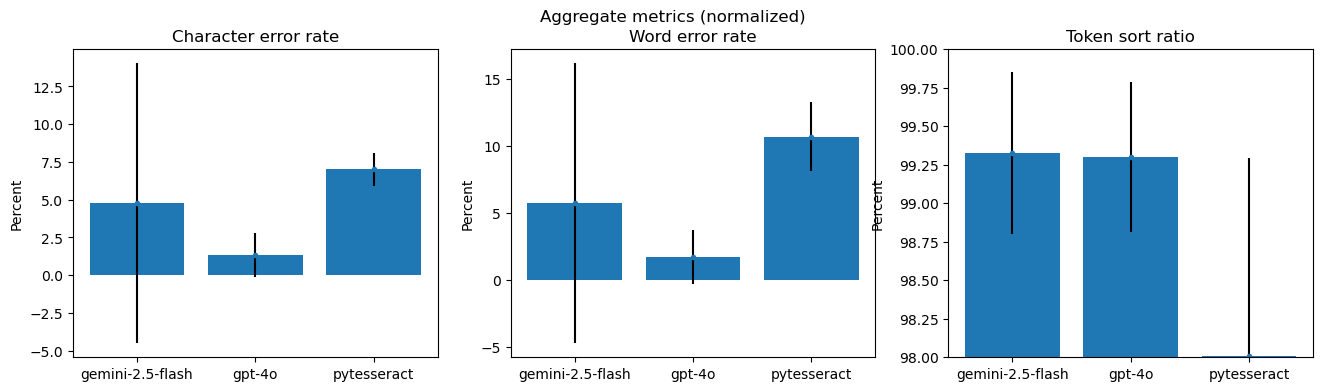

In [304]:
fig, (cer_ax, wer_ax, tsr_ax) = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

cer_pct = llm_txt_grouped_mean.loc['llm-img2txt', 'normalized', 'cer_pct']
wer_pct = llm_txt_grouped_mean.loc['llm-img2txt', 'normalized', 'wer_pct']
tsr_pct = llm_txt_grouped_mean.loc['llm-img2txt', 'normalized', 'token_sort_ratio']
models = ['gemini-2.5-flash', 'gpt-4o', 'pytesseract']

cer_std = llm_txt_grouped_std.loc['llm-img2txt', 'normalized', 'cer_pct']
wer_std = llm_txt_grouped_std.loc['llm-img2txt', 'normalized', 'wer_pct']
tsr_std = llm_txt_grouped_std.loc['llm-img2txt', 'normalized', 'token_sort_ratio']

print(cer_pct)

fig.suptitle('Aggregate metrics (normalized)')

cer_ax.errorbar(models, cer_pct, yerr=cer_std, ecolor='black', fmt='.')
cer_ax.bar(models, cer_pct)
cer_ax.set_title('Character error rate')
cer_ax.set_ylabel('Percent')
wer_ax.errorbar(models, wer_pct, yerr=wer_std, ecolor='black', fmt='.')
wer_ax.bar(models, wer_pct)
wer_ax.set_title('Word error rate')
wer_ax.set_ylabel('Percent')
tsr_ax.errorbar(models, tsr_pct, yerr=tsr_std, ecolor='black', fmt='.')
tsr_ax.bar(models, tsr_pct)
tsr_ax.set_title('Token sort ratio')
tsr_ax.set_ylabel('Percent')
tsr_ax.set_ylim(np.floor(np.min(tsr_pct)), 100)

# Histogram of error rates across individual pages

In [305]:
# Get all CER rates of individual pages
all_cer_pct = llm_txt[
    ~txt_all_docs &
    (llm_txt['metric'] == 'cer_pct') &
    (llm_txt['cleaning_method'] == 'normalized') &
    (llm_txt['sub_dir'] == 'ocr-llm-img2txt')
]
all_wer_pct = llm_txt[
    ~txt_all_docs &
    (llm_txt['metric'] == 'wer_pct') &
    (llm_txt['cleaning_method'] == 'normalized') &
    (llm_txt['sub_dir'] == 'ocr-llm-img2txt')
]

100.0


Text(0.5, 0, 'Character error rate (%)')

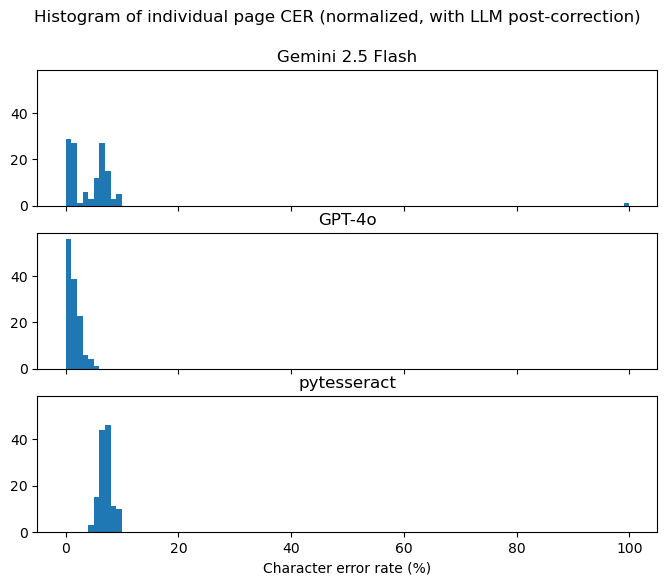

In [306]:
# Compare error rates of different models/methods
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(8, 6), sharex=True, sharey=True)
fig.suptitle('Histogram of individual page CER (normalized, with LLM post-correction)')

print(np.ceil(np.max(all_cer_pct.drop(DF_INFO_COLS, axis='columns'))))

bin_width_even = range(0, int(np.ceil(np.max(all_cer_pct.drop(DF_INFO_COLS, axis='columns'))) + 1), 1)

ax0.hist(all_cer_pct['gemini-2.5-flash'], bins=bin_width_even)
ax0.set_title('Gemini 2.5 Flash')
ax1.hist(all_cer_pct['gpt-4o'], bins=bin_width_even)
ax1.set_title('GPT-4o')
ax2.hist(all_cer_pct['pytesseract'], bins=bin_width_even)
ax2.set_title('pytesseract')
ax2.set_xlabel('Character error rate (%)')

# Bar graph displaying frequencies of CER by category

In [308]:
def er_freqs_from(df):
    error_rates_only = df.drop(columns=DF_INFO_COLS)
    er_less_than_1 = (error_rates_only < 1).sum()
    er_between_1_5 = ((error_rates_only >= 1) & (error_rates_only < 5)).sum()
    er_greater_than_5 = (error_rates_only >= 5).sum()
    er_combined = pd.DataFrame({
        "error <1%": er_less_than_1,
        "1% <= error < 5%": er_between_1_5,
        "error >= 5%": er_greater_than_5
    }).transpose()
    return er_combined
cer_combined = er_freqs_from(all_cer_pct)
wer_combined = er_freqs_from(all_wer_pct)

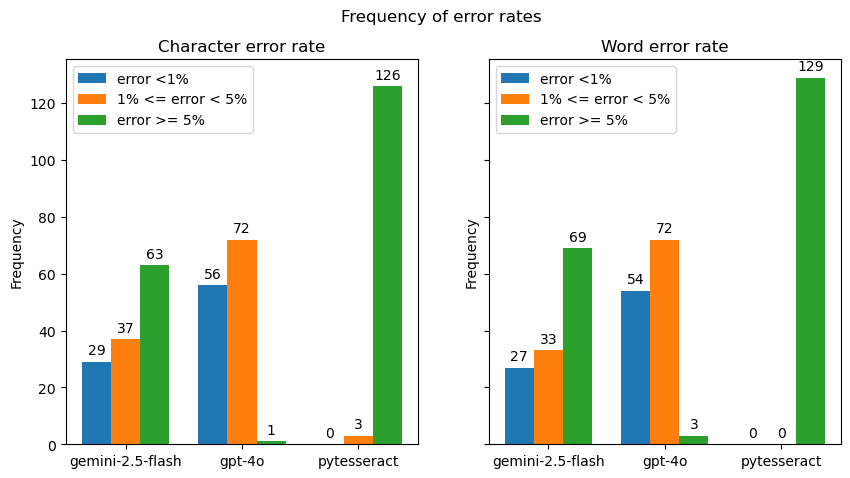

In [309]:
# Similar histogram as above, but uses separately-sized bins.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)

models = ['gemini-2.5-flash', 'gpt-4o', 'pytesseract']

fig.suptitle('Frequency of error rates')

# cer_ax.bar(models, cer_pct)
for ax, data, title in zip(
    axes,
    [cer_combined, wer_combined],
    ["Character error rate", "Word error rate"]
):
    width = 0.25
    multiplier = 0

    x = np.arange(len(models))

    ax.set_title(title)
    ax.set_ylabel('Frequency')
    for index, row in data.iterrows():
        offset = width * multiplier
        rects = ax.bar(x + offset, row, width, label=index)
        ax.bar_label(rects, padding=3)
        multiplier += 1

    ax.set_xticks(x + width, models)
    ax.legend(loc='upper left')